In [32]:
import pandas as pd 
import geopandas as gpd 
import numpy as np 

import matplotlib.pyplot as plt
import osmnx as ox

from glob import glob
from tqdm import tqdm

In [2]:
# turn on latex plotting 
plt.rc('text', usetex=False)

In [3]:
import sys 
import os
# add parent directory to path
sys.path.insert(1, os.path.join(sys.path[0], '..'))


In [4]:
from user.params.data import *

In [5]:
nyc_roads = ox.io.load_graphml('../data/geo/nyc.graphml')

In [6]:
nyc_roads_gdf = ox.graph_to_gdfs(nyc_roads, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
nyc_roads_gdf = nyc_roads_gdf.to_crs(PROJ_CRS)

In [7]:
nyc_ct = gpd.read_file('../data/geo/nyc_ct/nyct2020.shp')
nyc_ct = nyc_ct.to_crs(PROJ_CRS)

In [8]:
nyc_311 = pd.read_csv('../data/geo/311_Service_Requests_from_2010_to_Present.csv', engine='pyarrow')

In [9]:
nyc_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2402947 entries, 0 to 2402946
Data columns (total 46 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unique Key                      int64  
 1   Created Date                    object 
 2   Closed Date                     object 
 3   Agency                          object 
 4   Agency Name                     object 
 5   Complaint Type                  object 
 6   Descriptor                      object 
 7   Location Type                   object 
 8   Incident Zip                    object 
 9   Incident Address                object 
 10  Street Name                     object 
 11  Cross Street 1                  object 
 12  Cross Street 2                  object 
 13  Intersection Street 1           object 
 14  Intersection Street 2           object 
 15  Address Type                    object 
 16  City                            object 
 17  Landmark                   

In [10]:
# make output/eda directory if it doesn't exist
if not os.path.exists('../output/eda'):
    os.makedirs('../output/eda')
nyc_311['Complaint Type'].value_counts().sort_values(ascending=False).to_csv('../output/eda/311_complaint_types.csv')

In [11]:
# make output/eda directory if it doesn't exist
if not os.path.exists('../output/eda'):
    os.makedirs('../output/eda')
nyc_311['Descriptor'].value_counts().sort_values(ascending=False).to_csv('../output/eda/311_descriptor_counts.csv')

In [12]:
list(nyc_311['Complaint Type'].unique())

['Derelict Vehicles',
 'Street Condition',
 'Noise - Street/Sidewalk',
 'Illegal Parking',
 'Noise - Residential',
 'Noise - Park',
 'Rodent',
 'Consumer Complaint',
 'Blocked Driveway',
 'Traffic',
 'Noise - Vehicle',
 'Panhandling',
 'Homeless Person Assistance',
 'Food Establishment',
 'Smoking',
 'Noise - Commercial',
 'Dirty Condition',
 'Sanitation Worker or Vehicle Complaint',
 'Litter Basket Complaint',
 'Residential Disposal Complaint',
 'Non-Emergency Police Matter',
 'Illegal Dumping',
 'Encampment',
 'Overgrown Tree/Branches',
 'New Tree Request',
 'Street Light Condition',
 'Municipal Parking Facility',
 'Taxi Complaint',
 'Drinking',
 'Street Sign - Dangling',
 'Noise',
 'PAINT/PLASTER',
 'UNSANITARY CONDITION',
 'WATER LEAK',
 'HEAT/HOT WATER',
 'Traffic Signal Condition',
 'Mobile Food Vendor',
 'Root/Sewer/Sidewalk Condition',
 'Vendor Enforcement',
 'Drug Activity',
 'Animal-Abuse',
 'Missed Collection',
 'Air Quality',
 'GENERAL',
 'Abandoned Vehicle',
 'SAFETY',
 'D

In [13]:
nyc_311['Created Date'] = pd.to_datetime(nyc_311['Created Date'])

In [14]:
nyc_311_gdf = gpd.GeoDataFrame(nyc_311, geometry=gpd.points_from_xy(nyc_311.Longitude, nyc_311.Latitude), crs='EPSG:4326')
nyc_311_gdf = nyc_311_gdf.to_crs(PROJ_CRS)

<Axes: >

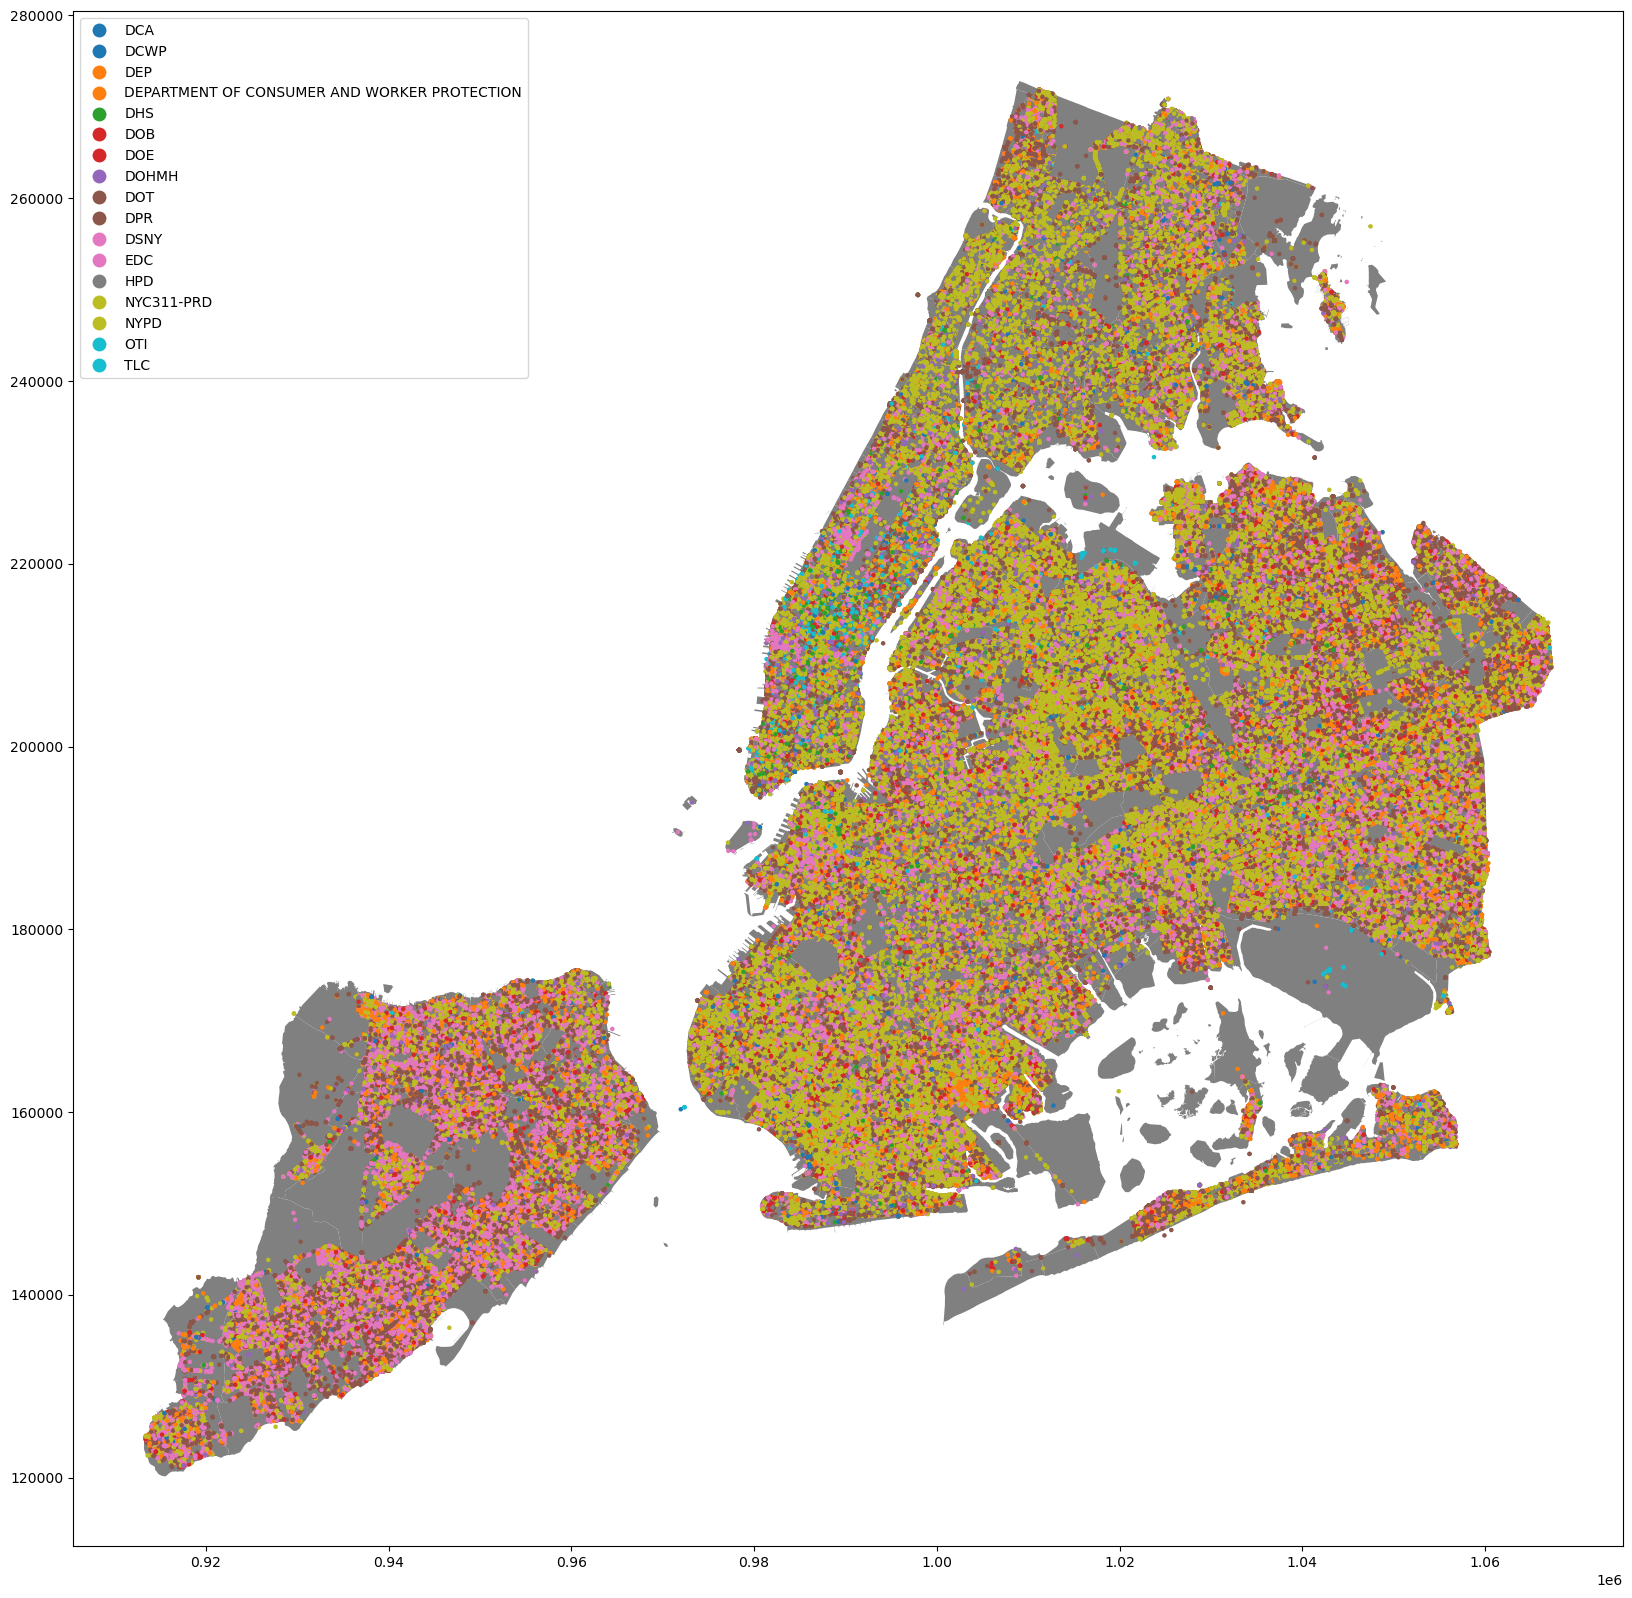

In [15]:
fig, ax = plt.subplots(figsize=(20,20))
nyc_ct.plot(ax=ax, color='grey', linewidth=0.5)
nyc_311_gdf.plot(ax=ax, column='Agency', legend=True, markersize=5)

In [16]:
# filter on rows created on september 29th 2023
sep29 = nyc_311_gdf[nyc_311_gdf['Created Date'].dt.date == pd.to_datetime('2023-09-29').date()]

In [17]:
sep29['Descriptor'].value_counts()

Descriptor
Sewer Backup (Use Comments) (SA)    1055
HEAVY FLOW                          1038
Street Flooding (SJ)                 618
Loud Music/Party                     611
SLOW LEAK                            463
                                    ... 
Curb Defect-Metal Protruding           1
Clothing/Glasses                       1
Street Light Lamp Missing              1
Obstructing Public Use                 1
Idling or Blocking Traffic             1
Name: count, Length: 405, dtype: int64

In [18]:
flooding_descs = ['Catch Basin Clogged/Flooding (Use Comments) (SC)', 'Sewer Backup (Use Comments) (SA)', 'Street Flooding (SJ)', 'Highway Flooding (SH)', 'SLOW LEAK', 'Leak (Use Comments) (WA2)', 'Hydrant Leaking (WC1)', 'Sewage Leak', 'HEAVY FLOW', 'Overflowing', 'Manhole Overflow (Use Comments) (SA1)', 'WATER SUPPLY', 'Dirty Water (WE)', 'Failure To Retain Water/Improper Drainage- (LL103/89)', 'Excessive Water In Basement (WEFB)', 'Puddle on Sidewalk', 'Puddle on Driveway'] 

In [19]:
flooding = sep29[sep29['Descriptor'].isin(flooding_descs)]

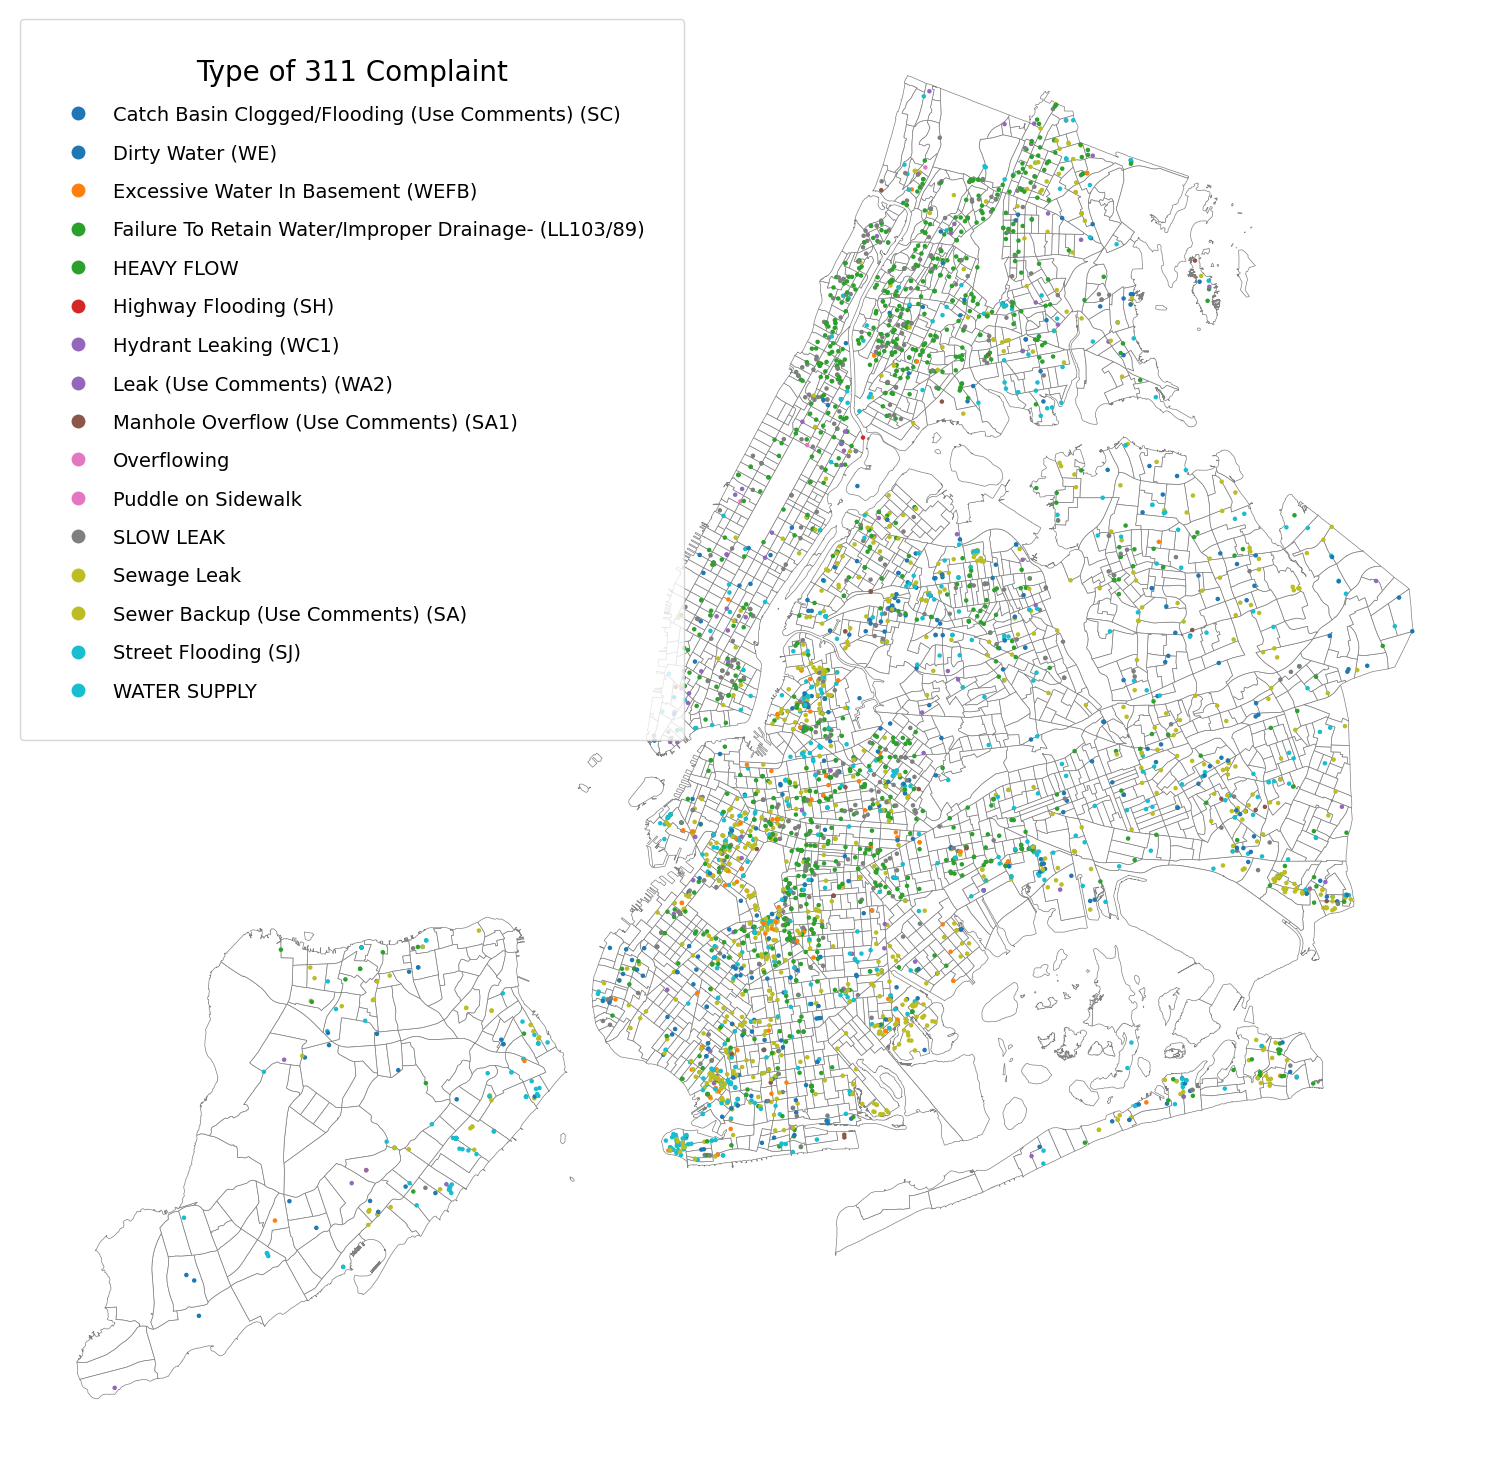

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
nyc_ct.plot(ax=ax, edgecolor='grey', color='w', linewidth=0.5)
flooding.plot(ax=ax, column='Descriptor', markersize=5, legend=True, legend_kwds={'loc': 'upper left', 'title': 'Type of 311 Complaint', 'borderpad':2, 'labelspacing': 1, 'fontsize': 14})

# increase legend font size 
leg = ax.get_legend() 

# increase legend title size 
leg.get_title().set_fontsize('20')




plt.axis('off')
# tight layout
plt.tight_layout()

plt.savefig('../output/plots/311_flooding.png', dpi=400, bbox_inches='tight')


In [21]:
flooding.to_csv('../data/coords/sep29_flooding.csv', index=False)

In [22]:
nyc_ct_w_flooding_reports = nyc_ct.merge(flooding.sjoin_nearest(nyc_ct, how='left').groupby('BoroCT2020').size().to_frame(), on='BoroCT2020', how='left').fillna(0)

In [23]:
nyc_ct.merge(flooding.sjoin_nearest(nyc_ct, how='left').groupby('BoroCT2020').size().to_frame(), on='BoroCT2020', how='left').fillna(0).describe()

,CDEligibil,Shape_Leng,Shape_Area,0
count,2325.0,2325.000000,2.325000e+03,2325.000000
mean,0.0,8451.424348,3.622741e+06,1.696344
std,0.0,7559.852193,7.163484e+06,2.821086
min,0.0,2569.477865,4.005503e+05,0.000000
25%,0.0,5539.379109,1.631792e+06,0.000000
50%,0.0,6459.690172,1.964157e+06,1.000000
75%,0.0,8713.651554,3.087463e+06,2.000000
max,0.0,148864.816639,1.971899e+08,52.000000


In [24]:
# rename '0' column to 'flood_reports'
nyc_ct_w_flooding_reports.rename(columns={0: 'flood_reports'}, inplace=True)

In [25]:
value_counts = nyc_ct_w_flooding_reports.flood_reports.value_counts().sort_index()

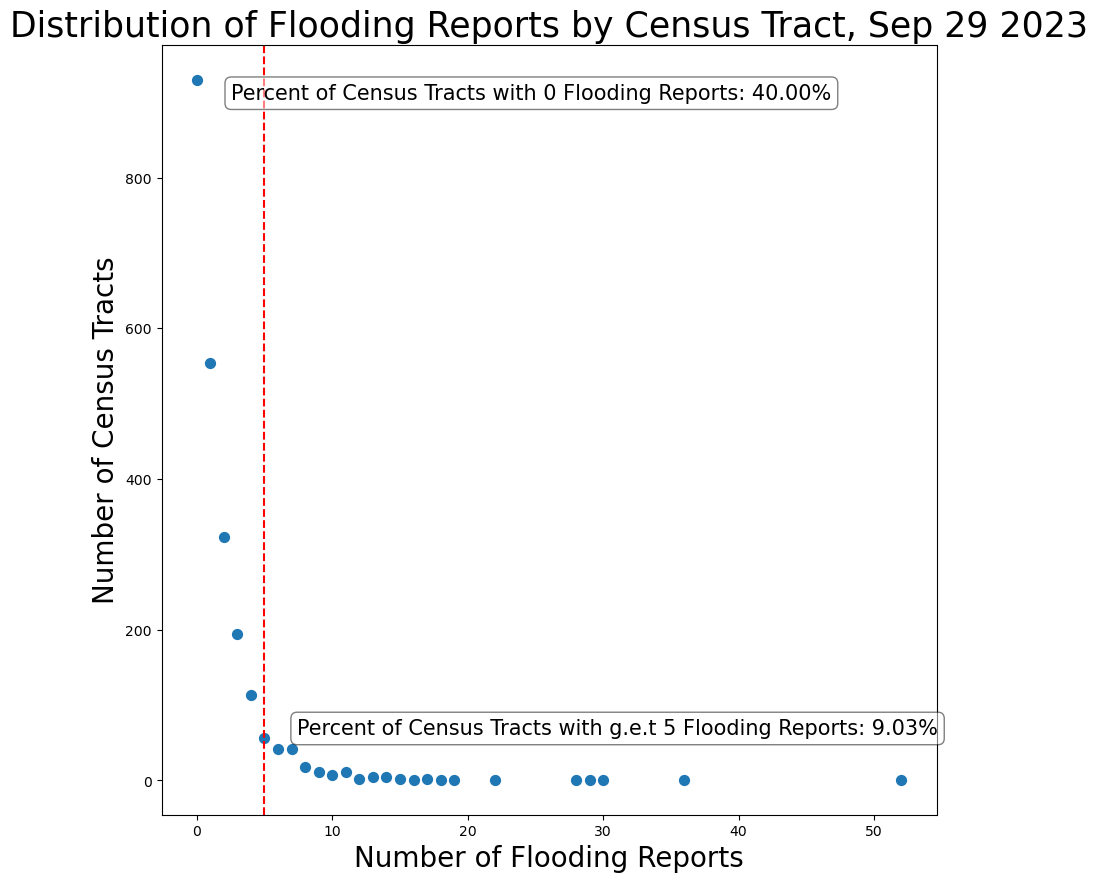

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
# scatter plot with trendline
ax.scatter(value_counts.index, value_counts.values, s=50)
ax.set_xlabel('Number of Flooding Reports', fontsize=20)
ax.set_ylabel('Number of Census Tracts', fontsize=20)
ax.set_title('Distribution of Flooding Reports by Census Tract, Sep 29 2023', fontsize=25)

# add box with percent of census tracts with 0 flooding reports
ax.text(0.09, 0.95, 'Percent of Census Tracts with 0 Flooding Reports: {:.2f}%'.format(value_counts[0]/len(nyc_ct_w_flooding_reports)*100), transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# add box with percent of census tracts with > 5 flooding reports
ax.text(0.175, 0.125, 'Percent of Census Tracts with g.e.t 5 Flooding Reports: {:.2f}%'.format(value_counts[value_counts.index >= 5].sum()/len(nyc_ct_w_flooding_reports)*100), transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# red dashed vertical line at x=5 
ax.axvline(x=5, linestyle='--', color='red')


plt.savefig('../output/plots/311_flooding_dist.png', dpi=400, bbox_inches='tight')


In [27]:
nyc_ct_w_flooding_reports.flood_reports.describe()

count    2325.000000
mean        1.696344
std         2.821086
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        52.000000
Name: flood_reports, dtype: float64

In [30]:
samples = glob('./output/*/')
samples

['./output/flooding_929_WATER SUPPLY_1000_2023-09-29/',
 './output/flooding_929_Sewer Backup (Use Comments) (SA)_1000_2023-09-29/',
 './output/flooding_929_SLOW LEAK_1000_2023-09-29/',
 './output/flooding_929_HEAVY FLOW_1000_2023-09-29/',
 './output/flooding_929_Street Flooding (SJ)_1000_2023-09-29/',
 './output/flooding_929_Catch Basin Clogged/',
 './output/flooding_929_Excessive Water In Basement (WEFB)_1000_2023-09-29/',
 './output/flooding_929_Failure To Retain Water/',
 './output/flooding_929_Leak (Use Comments) (WA2)_1000_2023-09-29/',
 './output/flooding_929_Dirty Water (WE)_1000_2023-09-29/',
 './output/flooding_929_Sewage Leak_1000_2023-09-29/',
 './output/flooding_929_Manhole Overflow (Use Comments) (SA1)_1000_2023-09-29/',
 './output/flooding_929_Highway Flooding (SH)_1000_2023-09-29/',
 './output/flooding_929_Hydrant Leaking (WC1)_1000_2023-09-29/',
 './output/flooding_929_Overflowing_1000_2023-09-29/',
 './output/flooding_929_Puddle on Sidewalk_1000_2023-09-29/']

In [33]:
sep29_md = pd.concat([pd.read_csv(x, engine='pyarrow') for x in tqdm(glob("../../nexar_data/2023/2023-09-29/*/metadata.csv"))])

100%|██████████| 41/41 [00:03<00:00, 13.36it/s]


In [64]:
for sample in samples: 
    
    imgs = glob(f"{sample}/*.jpg")

    frame_ids = [img.split('/')[-1].split('.')[0] for img in imgs]

    frames = sep29_md[sep29_md['frame_id'].isin(frame_ids)]

    frames = gpd.GeoDataFrame(frames, geometry=gpd.points_from_xy(frames['gps_info.longitude'], frames['gps_info.latitude']), crs='EPSG:4326')
    frames = frames.to_crs(PROJ_CRS)

    #print(frames)
    



    fig, ax = plt.subplots(figsize=(15,15))

    nyc_roads_gdf.plot(ax=ax, color='grey', linewidth=0.5, alpha=0.25)
    
    nyc_ct.plot(ax=ax, edgecolor='black', color='w', linewidth=0.5, alpha=0.2)
    print(sample.rsplit('_',4)[2])
    flooding_sample = flooding[flooding['Descriptor'] == sample.rsplit('_',4)[2]]
    flooding_sample = gpd.GeoDataFrame(flooding_sample, geometry=gpd.points_from_xy(flooding_sample.Longitude, flooding_sample.Latitude), crs='EPSG:4326')
    flooding_sample = flooding_sample.to_crs(PROJ_CRS)

    flooding_sample.plot(ax=ax, color='g', markersize=5.5,legend=False)
    frames.plot(ax=ax, markersize=4)

    ax.legend(['NYC Roads', 'Flooding Reports', 'Nexar Images'], loc='upper left', fontsize=15)

    ax.set_title(f'Sample v. Reports: {sample.rsplit("_",4)[2]}', fontsize=25)

    os.makedirs('../output/plots/flooding_sample_verification', exist_ok=True)

    plt.axis('off')


    plt.savefig(f'../output/plots/flooding_sample_verification/{sample.rsplit("_",4)[2].replace("/","")}.png', dpi=400, bbox_inches='tight')

    plt.clf()
    
    

WATER SUPPLY
Sewer Backup (Use Comments) (SA)
SLOW LEAK
HEAVY FLOW
Street Flooding (SJ)
Catch Basin Clogged/


/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Excessive Water In Basement (WEFB)
Failure To Retain Water/


/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Leak (Use Comments) (WA2)
Dirty Water (WE)
Sewage Leak
Manhole Overflow (Use Comments) (SA1)
Highway Flooding (SH)
Hydrant Leaking (WC1)
Overflowing
Puddle on Sidewalk


<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>